In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import csv

import duckdb

conn = duckdb.connect('mydb.db') # create an in-memory database

In [2]:
conn.sql("SHOW ALL TABLES")

┌──────────┬─────────┬─────────────┬───────────────────────────┬──────────────────────────────────────┬───────────┐
│ database │ schema  │    name     │       column_names        │             column_types             │ temporary │
│ varchar  │ varchar │   varchar   │         varchar[]         │              varchar[]               │  boolean  │
├──────────┼─────────┼─────────────┼───────────────────────────┼──────────────────────────────────────┼───────────┤
│ mydb     │ main    │ SI_VI_AD0   │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ SI_VI_AD1   │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ SI_VI_RPTR0 │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ SI_VI_RPTR1 │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ TBB         │ [Tiles, ADbc, RPTRbc]     │ [VARCHA

In [3]:
pwd

'/global/scratch/users/empchase/CiberVI/Analysis'

In [4]:
path = '/global/scratch/users/empchase/CiberVI/Analysis/SIread1/'

directory = os.fsencode(path)
AD1files = []
RPTR1files = []

for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.fastq'):
#         print (type(filename))
#         read1files.append(filename)
#         print(type(filename))
        x = filename.split('_')
#         print(x)
        if 'AD' in x:
            AD1files.append(filename)
        elif 'RPTR' in x:
            RPTR1files.append(filename)
            
print(AD1files)
print(RPTR1files)

['Staller_AD_4_30_1_MVS_0001_I1_AACGCAATTC_CGTATCCGTA_S323_R1_001.fastq', 'Staller_AD_4_30_0_MVS_0003_I1_TGGACTCGAA_TTCCGTATTG_S325_R1_001.fastq']
['Staller_RPTR_4_30_1_MVS_0002_I1_CGTCGCTAAG_AATACCAGGA_S324_R1_001.fastq', 'Staller_RPTR_4_30_0_MVS_0004_I1_TTAGGTTGTC_TCTTCAACCG_S326_R1_001.fastq', 'shortStaller_RPTR_4_30_0_MVS_0004_I1_TTAGGTTGTC_TCTTCAACCG_S326_R1_001.fastq']


In [5]:
def complement(seq):
    complement = {'A': 'T', 'C': 'G', 'G': 'C', 'T': 'A', 'N':'N', 'X':'X'} 
    bases = list(seq) 
    bases = [complement[base] for base in bases] 
    return ''.join(bases)
def reverse_complement(s):
        return complement(s[::-1])

In [12]:
def getmid(seq, pre, post, bclen):
    # seq = the sequence to parse
    # pre = substring that precedes piece of interest
    # post = substring that follows piece of interest
    # returns piece of interest

    re_key = pre + "(.*)"+ post 
    poi_search = re.search(re_key, seq)
#     print(poi_search)


    if poi_search is None:
        #the barcode will be called X
        poi = "X"
        
        #then we search for which restriction site had the error
        #regex for the bc we want to ignore
        w = "(.{"+str(bclen)+"})" 
#         print(w)
        pre_re = pre + w + "(.{7})"
        pre_search = re.search(pre_re, seq)
#         print(pre_search)
        post_re = "(\w{7})" + w + post
        post_search = re.search(post_re, seq)
#         print(post_search)
        
        if pre_search is None and post_search is None:
            a = 'X'
            z = 'X'
        elif pre_search is None:
            poi = post_search.group(2)
            a = post_search.group(1)
            z = post
        elif post_search is None:
            poi = pre_search.group(1)
            z = pre_search.group(2)
            a = pre
            
    else:
        poi = poi_search.group(1)
        a = pre
        z = post
    
    return poi, a, z


#putative consensus sequences ***reverse complement of snapgene***
adp = 'CGGGCCC'#7 bp ; beforeAD barcode in read1
adf = 'GGCGCGC' #7bp ; after AD barcode in read1

rpp = 'AGCGGCC' #7bp ; before rptr barcode in read1
rpf = 'CTCGAGT' #7 bp ; after rptr barcode in read1


# function that just looks for bc
def bc_finder(readfile,bc_pre, bc_post, bc_len):

    # make lists of reads
    seqlist = []
    
    with open(readfile, 'r') as fin:
        for line in fin:
            if line.startswith('@M'):
                #look at next line to get read sequence, add to list
                seq = next(fin)
                seq = seq.strip()
                seqlist.append(seq)

    
    #make lists of BCs from list of reads
    bc_list = []
    bc_lens = []
    q_list = []
    
    prex_list = []
#     prex_len = []
    postx_list = []
#     postx_len = []
       
    for read in seqlist:
   
        bc, prex, postx = getmid(read, bc_pre, bc_post, bc_len)
        bc = reverse_complement(bc) #return reverse complement
        bc_list.append(bc)
        bcl = len(bc)
        bc_lens.append(bcl)
        
        #restriction sites: not doing reverse complement
        prex_list.append(prex)
#         prex_len.append(len(prex))
        postx_list.append(postx)
#         postx_len.append(len(postx))
        if bcl == bc_len:
            q_list.append(1)
        else:
            q_list.append(0)
    #         print(bc)

               
    # make the df
    
#     print(len(bc_list))
#     print(len(bc_lens))
#     print(len(q_list))
#     print(len(prex_list))
#     print(len(prex_len))
#     print(len(postx_list))
#     print(len(postx_len))
    
    BC_dict = {"BCs":bc_list, "Length":bc_lens, #"Qual":q_list, 
               "prex":prex_list, #'prexl':prex_len,
               'postx':postx_list, #'postxl':postx_len
              } 
    BC_df = pd.DataFrame.from_dict(BC_dict)
    
    return BC_df

In [13]:
#read in TBB Table as df and create dictionary
tbbdf = conn.sql("""SELECT * FROM TBB_UNION""").df()

#dictionary ~ {RPTRbc: TBB}
RPTRdict = dict(zip(tbbdf.RPTRbc, tbbdf.TBB))

tbbdf.head()

,Tile,ADbc,RPTRbc,TBB
0,GATTTGCAAGGTAAATTCTTGGCTGCTCCATTGGAAGAGAATCCAA...,TTTATCCTCGG,AAAAAATTACTTGG,GATTTGCAAGGTAAATTCTTGGCTGCTCCATTGGAAGAGAATCCAA...
1,GACCCATATATGTCTGCTCCAAATTCTACTGCATTTACTGCTTTGA...,TGAAATGGTAA,CAAAAAGCTATGGT,GACCCATATATGTCTGCTCCAAATTCTACTGCATTTACTGCTTTGA...
2,GCTTTGGCTGGTGATCCATGGTATCCATTGTTTCCACAAGATGATC...,TGGTAATGAGA,TTTAAATGGCTAAT,GCTTTGGCTGGTGATCCATGGTATCCATTGTTTCCACAAGATGATC...
3,GATTATCATTCTCAAGCTACTGCTGACTTTGTCTTGTATCCACAAG...,AAGGTCCGAGG,AACAAATACAGAGT,GATTATCATTCTCAAGCTACTGCTGACTTTGTCTTGTATCCACAAG...
4,GATATTGAAGCTAGATCATTCTATGTCTTTGGTTCTCCAGTTTCTC...,CCCCGCCGTCG,TCTAGGTTTCACCC,GATATTGAAGCTAGATCATTCTATGTCTTTGGTTCTCCAGTTTCTC...


In [14]:
#dictionary ~ {ADbc: TBB}

#nt this function overwrites the value of any repeated key, dictionary is only useful to know if there EXISTS an AD BC Match 
ADdict = dict(zip(tbbdf.ADbc, tbbdf.TBB)) 

In [15]:
def analyze_bcs (df, bc_len, bcdict):
    # df = barcode containing df, parsed from fastq
    # bc_len = int, expected barcode length
    # tbb_dictkey = str, either 'ADbc' or 'RPTRbc'
    
    print('total reads')
    print(df.shape[0]) #how many total reads
    
    cls = df[df['Length']== bc_len] #cl = correct length
    print('BCs of correct length')
    print(cls.shape[0])
    
    print('% BCs of correct length')
    print (cls.shape[0]/df.shape[0])
    
    #df of BC coverage
    cl_covdf = cls['BCs'].value_counts().to_frame().reset_index() 
    print('# Unique BCs')
    print(cl_covdf.shape[0])
#     print('SUM Unique BCs')
#     print(cl_covdf.sum(numeric_only=True)['BCs'])

    #copy down unique BCs into a list
    bcs = cl_covdf['index'].tolist()
    

    
    
    print('# BC matches to A10 deep seq map')

    matchlist = [] #list of TBBs that match the BCs
#     matches = 0
    for x in bcs:
        try:
            tbb = bcdict[x]
        except KeyError:
            matchlist.append(0)
        else:
            matchlist.append(tbb)
#             matches += 1
            

            
    cl_covdf['TBB'] = matchlist
    
    matchesonly = cl_covdf.replace(0, np.nan)
    matchesonly = matchesonly.dropna()
    totmatches = matchesonly.sum(numeric_only=True)['BCs']
    
#     print(matches)
    print(matchesonly.shape[0])
    
    print('TOT BC matches to A10 deep seq map')
    print(totmatches)
    
#     print('% unique BCs matched')
#     print(totmatches/cl_covdf.shape[0])
    
    
    print()
    
    return cl_covdf
    

In [16]:
# make df out of each fastq file
Alist = []
Rlist = []

for file in AD1files:
    fp = path + file
    x = bc_finder(fp, adp, adf, 11)
    Alist.append(x)


for file in RPTR1files:
    fp = path + file
    x = bc_finder(fp, rpp, rpf, 14)
    Rlist.append(x)

In [17]:
testtest = Rlist[2]
testtest[testtest['Length']==1]

,BCs,Length,prex,postx
5,X,1,X,X
6,X,1,X,X
7,X,1,X,X


In [18]:
#Test
print(Rlist[2])
shorttest = analyze_bcs(Rlist[2], 14, RPTRdict)
shorttest.head()

              BCs  Length     prex    postx
0  TGTGGGCATGTTAG      14  AGCGGCC  CTCGAGT
1  TGGAGAAAGAAAAT      14  AGCGGCC  CTCGAGT
2  TGTGGGCATGTTAG      14  NGCGGCC  CTCGAGT
3  TGTGGGCATGTTAG      14  NGCGGCC  CTCGAGT
4  TGTGGGCATGTTAG      14  AGCGGCC  CTCGAGT
5               X       1        X        X
6               X       1        X        X
7               X       1        X        X
8  CTCAATCGACAATT      14  AGCGGCC  CTCGAGT
total reads
9
BCs of correct length
6
% BCs of correct length
0.6666666666666666
# Unique BCs
3
# BC matches to A10 deep seq map
2
TOT BC matches to A10 deep seq map
5



,index,BCs,TBB
0,TGTGGGCATGTTAG,4,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...
1,TGGAGAAAGAAAAT,1,0
2,CTCAATCGACAATT,1,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...


In [19]:
RPTR_4_30_0 = analyze_bcs (Rlist[1], 14, RPTRdict)
RPTR_4_30_0.head()

total reads
690741
BCs of correct length
318637
% BCs of correct length
0.4612973603709639
# Unique BCs
1987
# BC matches to A10 deep seq map
179
TOT BC matches to A10 deep seq map
179170



,index,BCs,TBB
0,TGGAGAAAGAAAAT,85986,0
1,ACTTCTAAATAAGC,77342,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...
2,TGTGGGCATGTTAG,74370,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...
3,GAAACACTAAATTC,22384,0
4,CTCAATCGACAATT,17211,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...


In [20]:
RPTR_4_30_1 = analyze_bcs (Rlist[0], 14, RPTRdict)
RPTR_4_30_1.head()

total reads
688729
BCs of correct length
572666
% BCs of correct length
0.8314823392074386
# Unique BCs
2972
# BC matches to A10 deep seq map
239
TOT BC matches to A10 deep seq map
327859



,index,BCs,TBB
0,TGGAGAAAGAAAAT,173871,0
1,TGTGGGCATGTTAG,140158,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...
2,ACTTCTAAATAAGC,139711,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...
3,CTCAATCGACAATT,29314,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...
4,CCTGACTGATAGGG,24604,0


In [21]:
# rptrmatch0 = RPTR_4_30_0[RPTR_4_30_0['TBB']!=0]
rptrmatch0 = RPTR_4_30_0.replace(0, np.nan)
rptrmatch0 = rptrmatch0.dropna()
# rptrmatch1 = RPTR_4_30_1[RPTR_4_30_1['TBB']!=0]
rptrmatch1 = RPTR_4_30_1.replace(0, np.nan)
rptrmatch1 = rptrmatch1.dropna()


rtiles0 = []

for index, row in rptrmatch0.loc[:, ['TBB']].iterrows():
    try:
        #     print(row['TBB'])
        tbb_str = row['TBB']
        t = tbb_str.split('-')[0]
#         print(t)
    except AttributeError:
        t = 0 
    finally:
        rtiles0.append(t)


rptrmatch0['Tiles'] = rtiles0


####

rtiles1 = []

for index, row in rptrmatch1.loc[:, ['TBB']].iterrows():
    try:
        #     print(row['TBB'])
        tbb_str = row['TBB']
        t = tbb_str.split('-')[0]
#         print(t)
    except AttributeError:
        t = 0 
    finally:
        rtiles1.append(t)

rptrmatch1['Tiles'] = rtiles1
        
        
####
rptrdata_merge = rptrmatch1.merge(rptrmatch0, how='inner', on='Tiles', suffixes=('_1', '_0'))
# rptrdata_merge = rptrdata_merge.drop(labels=['TBB_1'], axis=1)
rptrdata_merge = rptrdata_merge.rename({'BCs_1':'RPTRbcs_1', 'BCs_0':'RPTRbcs_0'}, axis=1)

# rtiles = []

# rptrdata_merge['Tiles'] = rtiles
rptrdata_merge = rptrdata_merge.fillna(0)
rptrdata_merge

,index_1,RPTRbcs_1,TBB_1,Tiles,index_0,RPTRbcs_0,TBB_0
0,TGTGGGCATGTTAG,140158,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...,TGTGGGCATGTTAG,74370,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...
1,ACTTCTAAATAAGC,139711,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...,ACTTCTAAATAAGC,77342,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...
2,CTCAATCGACAATT,29314,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...,CTCAATCGACAATT,17211,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...
3,TTTAACGCATGAGT,15848,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,TTTAACGCATGAGT,8754,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...
4,ACTTCTAAAAAAGC,1088,TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATA...,TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATA...,ACTTCTAAAAAAGC,619,TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATA...
...,...,...,...,...,...,...,...
95,TGGAGTATGTTATT,1,GTTGTTGCTCCTAAACAAACTATTTCTAGAGAAGAATTGTTGTTGA...,GTTGTTGCTCCTAAACAAACTATTTCTAGAGAAGAATTGTTGTTGA...,TGTGGGCATGTTTT,1,GTTGTTGCTCCTAAACAAACTATTTCTAGAGAAGAATTGTTGTTGA...
96,CATTATAATAACGC,1,ATTCAAGCTACTGGTCATCAAACTACTTCTTCTGCATTTACTAATA...,ATTCAAGCTACTGGTCATCAAACTACTTCTTCTGCATTTACTAATA...,CATTATAATAACGC,1,ATTCAAGCTACTGGTCATCAAACTACTTCTTCTGCATTTACTAATA...
97,TGGATAAATATAAT,1,GCTGATAGAATTTCTGAAAATTCTAAGATGATTAAGACTGAAATTT...,GCTGATAGAATTTCTGAAAATTCTAAGATGATTAAGACTGAAATTT...,TGGATAAATATAAT,1,GCTGATAGAATTTCTGAAAATTCTAAGATGATTAAGACTGAAATTT...
98,AGTAGAAAGAAAAT,1,TTTGATAAATTTACTTCTGCTGATTCTATGGGTCAACAAGAATTGT...,TTTGATAAATTTACTTCTGCTGATTCTATGGGTCAACAAGAATTGT...,AGTAGAAAGAAAAT,1,TTTGATAAATTTACTTCTGCTGATTCTATGGGTCAACAAGAATTGT...


In [22]:
rptrdata_merge.corr(numeric_only=True)

,RPTRbcs_1,RPTRbcs_0
RPTRbcs_1,1.000000,0.999702
RPTRbcs_0,0.999702,1.000000


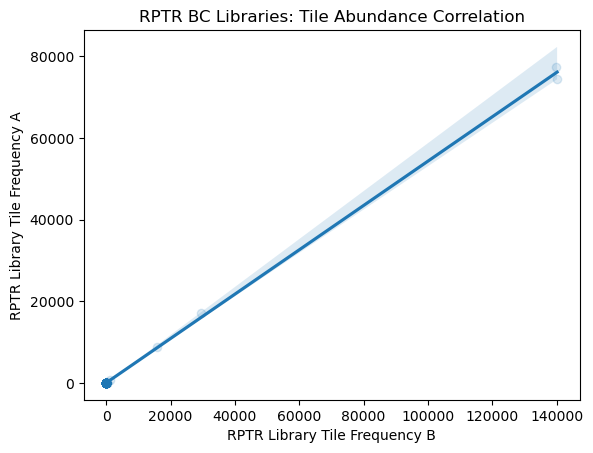

In [42]:
sns.regplot(x='RPTRbcs_1', y='RPTRbcs_0', data=rptrdata_merge, scatter_kws={'alpha':0.15}) #.set(title='RPTR BC Library 0 vs 1')

plt.title('RPTR BC Libraries: Tile Abundance Correlation')
plt.xlabel('RPTR Library Tile Frequency B')
plt.ylabel('RPTR Library Tile Frequency A')
# plt.xscale('log')
# plt.yscale('log')

plt.savefig('cibervi_RPTRlibcorr.png', dpi=300, format='png')
plt.show()

In [24]:
rptrdata_merge[(rptrdata_merge["RPTRbcs_1"]==1)&(rptrdata_merge["RPTRbcs_0"]==1)].shape

(17, 7)

In [26]:
rptrdata_merge_out = rptrmatch1.merge(rptrmatch0, how='outer', on='Tiles', suffixes=('_1', '_0'))
rptrdata_merge_out = rptrdata_merge_out.fillna(0)
rptrdata_merge_out

,index_1,BCs_1,TBB_1,Tiles,index_0,BCs_0,TBB_0
0,TGTGGGCATGTTAG,140158.0,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...,TGTGGGCATGTTAG,74370.0,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...
1,ACTTCTAAATAAGC,139711.0,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...,ACTTCTAAATAAGC,77342.0,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...
2,CTCAATCGACAATT,29314.0,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...,CTCAATCGACAATT,17211.0,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...
3,TTTAACGCATGAGT,15848.0,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,TTTAACGCATGAGT,8754.0,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...
4,ACTTCTAAAAAAGC,1088.0,TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATA...,TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATA...,ACTTCTAAAAAAGC,619.0,TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATA...
...,...,...,...,...,...,...,...
314,0,0.0,0,ATGTTTAATGGTGAACCAAATATGACTGATACTTCTGATTGGTTCT...,CCTTCTAAATAAGA,1.0,ATGTTTAATGGTGAACCAAATATGACTGATACTTCTGATTGGTTCT...
315,0,0.0,0,ATTCATGATTTGGATATGTCTCCAGCTTCTTCTTCTACTAATTTGG...,AATATTATATAAGC,1.0,ATTCATGATTTGGATATGTCTCCAGCTTCTTCTTCTACTAATTTGG...
316,0,0.0,0,GCTGCTTTGCAGAATCAAAGAGTTGCTGCTATTATTCAATCTACTG...,CTTGAAAAAAACGC,1.0,GCTGCTTTGCAGAATCAAAGAGTTGCTGCTATTATTCAATCTACTG...
317,0,0.0,0,ATGTCTGGTAGAGTTTCTTCTCCACCAGTTACTGTTCCACCAAGAG...,TGTTGTAACTAACA,1.0,ATGTCTGGTAGAGTTTCTTCTCCACCAGTTACTGTTCCACCAAGAG...


In [35]:
rptrdata_merge_out.sort_values('BCs_0',ascending=False)

,index_1,BCs_1,TBB_1,Tiles,index_0,BCs_0,TBB_0
1,ACTTCTAAATAAGC,139711.0,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...,ACTTCTAAATAAGC,77342.0,CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAA...
0,TGTGGGCATGTTAG,140158.0,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...,TGTGGGCATGTTAG,74370.0,GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTA...
2,CTCAATCGACAATT,29314.0,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...,CTCAATCGACAATT,17211.0,TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTA...
3,TTTAACGCATGAGT,15848.0,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,TTTAACGCATGAGT,8754.0,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...
4,ACTTCTAAAAAAGC,1088.0,TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATA...,TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATA...,ACTTCTAAAAAAGC,619.0,TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATA...
...,...,...,...,...,...,...,...
210,TATAACGCATTAGT,1.0,AGAGTTGCTGCTATTATTCAATCTACTGGTCATTCTATTTCTACTT...,AGAGTTGCTGCTATTATTCAATCTACTGGTCATTCTATTTCTACTT...,0,0.0,0
211,TGGTGTTATTTTTT,1.0,CAAATTTCATTTGATGATCCAGTCTTGTTTCCATCTCAACAAGCTC...,CAAATTTCATTTGATGATCCAGTCTTGTTTCCATCTCAACAAGCTC...,0,0.0,0
212,TGTGCTAATTTAAG,1.0,TCTATTTCTCATGGTAAACAAGGTAATAAGATGTTCTCTGAATTGG...,TCTATTTCTCATGGTAAACAAGGTAATAAGATGTTCTCTGAATTGG...,0,0.0,0
213,CCTCTCACCTACCG,1.0,GCTTATAATAGGAAACAAAGATCTATTCCATTGTCTCCAATTGTTC...,GCTTATAATAGGAAACAAAGATCTATTCCATTGTCTCCAATTGTTC...,0,0.0,0


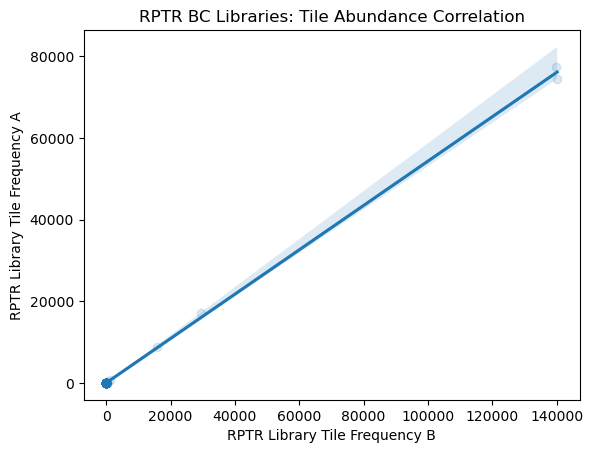

In [41]:
sns.regplot(x='BCs_1', y='BCs_0', data=rptrdata_merge_out, scatter_kws={'alpha':0.15}) #.set(title='RPTR BC Library 0 vs 1')

plt.title('RPTR BC Libraries: Tile Abundance Correlation')
plt.xlabel('RPTR Library Tile Frequency B')
plt.ylabel('RPTR Library Tile Frequency A')
# plt.xscale('log')
# plt.yscale('log')


# plt.savefig('cibervi_RPTRlibcorr_outer.png', dpi=300, format='png')
plt.show()

In [60]:
rptrdata_merge_out.corr(numeric_only=True)

,BCs_1,BCs_0
BCs_1,1.000000,0.999707
BCs_0,0.999707,1.000000


In [32]:
r_out_less = rptrdata_merge_out.drop(axis=1, columns=['index_1', 'TBB_1','index_0', 'TBB_0'])
r_out_less = r_out_less.set_index('Tiles')
r_out_less.head()

,BCs_1,BCs_0
Tiles,,
GGTAATTATTTGTTCTCTGCTGCTGCTCATGTTCATAGATCTTCTAGATTGTTTATGACTGTTGATGCTAGATCTTCTGATCAAATGAAGATTGTTGATCCAGATATTTGGGGTGAAGAT,140158.0,74370.0
CAATATAGAAGACAACAACCAGTTTCTCCAGCTGTTCAGAATCAAAGAGTTGCTCAATTGTTGCAAGCATTTGGTCATCCATCTTCTACTTCTAATTCTAGATTGCATAATCAATTCTAT,139711.0,77342.0
TTTCCAACTGCTAATATTCCATCTGAGTTCTTTAATTCATTTACTACTGATTCTAATCCAAGATGGTTGCCACCATCTTCTTCTTCTTTGCCAGCTCAATCTCCACAACAATTGTCTCAA,29314.0,17211.0
CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTACTCCATCTGACTTTCCATTTCCAGAAACTTTGACTTCTTCTACTGCTTCTAGATCTAGATTCTCTTTGCCAACT,15848.0,8754.0
TTGTTTAATGGTCAACAGAATCATAATCAGAATACTCAGAAATATAGAAGAGTTATGTCTACTCCAAACTTTATGGAAGCTCATGAAGTTGATTTGTTTGGTTTGCCATCTACTGACTTT,1088.0,619.0


<Axes: ylabel='Tiles'>

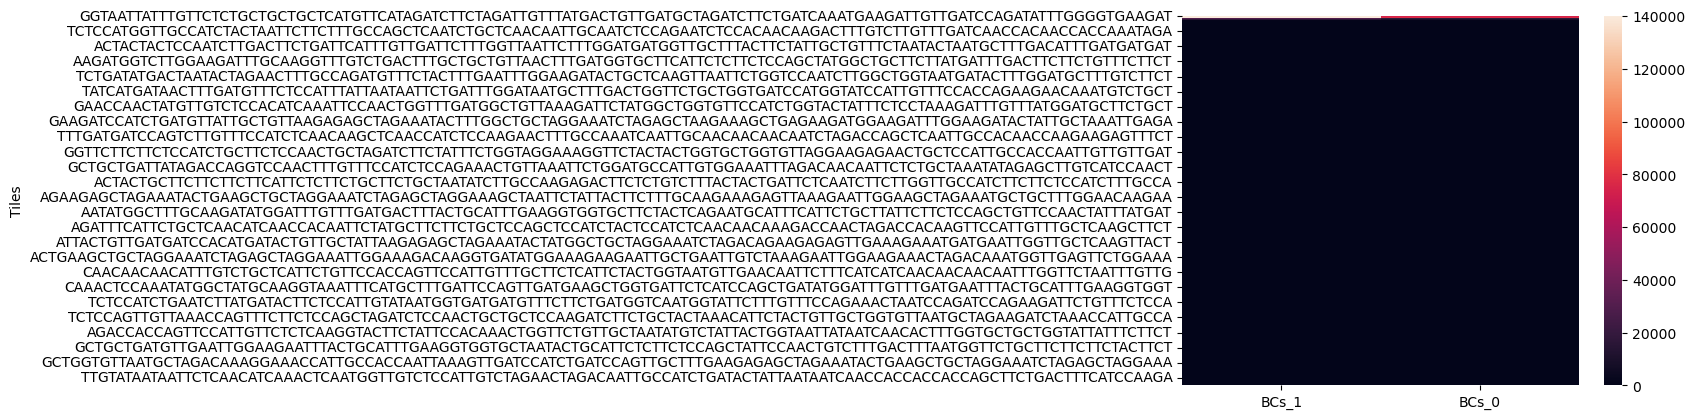

In [33]:
sns.heatmap(r_out_less)

In [43]:
AD_4_30_0 = analyze_bcs (Alist[1], 11, ADdict)

#get tiles column
AD_4_30_0
AD_4_30_0.head()

total reads
616507
BCs of correct length
599571
% BCs of correct length
0.9725291034813879
# Unique BCs
3210
# BC matches to A10 deep seq map
2568
TOT BC matches to A10 deep seq map
588434



,index,BCs,TBB
0,TACTTCATCAC,38470,GATGCATTTACTCCATTTGAAGGTGGTGCTTCTGTTACTAATGCAT...
1,TCTCTAACTGC,31440,TCTTCTACTGCTTTGCAAAGAAGAGGTCATCCATCTAGACCACCAG...
2,TGGCGGGGAGG,30245,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...
3,AGGATCATCCA,20301,TCTTATCAAGTTAGACCAAGACAAGAACCATTGCCACCAATCTTTA...
4,GTCCCCCTTAA,18131,TCTGGTACTGCTACTTCTCCACCAGCTCCAGCTGGTGGTGTTAGGA...


In [44]:
AD_4_30_1 = analyze_bcs (Alist[0], 11, ADdict)
AD_4_30_1.head()

total reads
114031
BCs of correct length
111430
% BCs of correct length
0.9771904131332708
# Unique BCs
978
# BC matches to A10 deep seq map
845
TOT BC matches to A10 deep seq map
109471



,index,BCs,TBB
0,TGGCGGGGAGG,12676,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...
1,TACTTCATCAC,9198,GATGCATTTACTCCATTTGAAGGTGGTGCTTCTGTTACTAATGCAT...
2,TCTCTAACTGC,6087,TCTTCTACTGCTTTGCAAAGAAGAGGTCATCCATCTAGACCACCAG...
3,AGGATCATCCA,5744,TCTTATCAAGTTAGACCAAGACAAGAACCATTGCCACCAATCTTTA...
4,GTCCCCCTTAA,4173,TCTGGTACTGCTACTTCTCCACCAGCTCCAGCTGGTGGTGTTAGGA...


In [45]:
admatch0 = AD_4_30_0[AD_4_30_0['TBB']!=0]
admatch1 = AD_4_30_1[AD_4_30_1['TBB']!=0]

In [46]:
# rptrmatch0 = RPTR_4_30_0[RPTR_4_30_0['TBB']!=0]
admatch0 = AD_4_30_0.replace(0, np.nan)
admatch0 = admatch0.dropna()
# rptrmatch1 = RPTR_4_30_1[RPTR_4_30_1['TBB']!=0]
admatch1 = AD_4_30_1.replace(0, np.nan)
admatch1 = admatch1.dropna()


atiles0 = []

for index, row in admatch0.loc[:, ['TBB']].iterrows():
    try:
        #     print(row['TBB'])
        tbb_str = row['TBB']
        t = tbb_str.split('-')[0]
#         print(t)
    except AttributeError:
        t = 0 
    finally:
        atiles0.append(t)


admatch0['Tiles'] = atiles0


####

atiles1 = []

for index, row in admatch1.loc[:, ['TBB']].iterrows():
    try:
        #     print(row['TBB'])
        tbb_str = row['TBB']
        t = tbb_str.split('-')[0]
#         print(t)
    except AttributeError:
        t = 0 
    finally:
        atiles1.append(t)

admatch1['Tiles'] = atiles1
        
        
####

addata_merge = admatch1.merge(admatch0, how='outer', on='Tiles', suffixes=('_1', '_0'))
addata_merge = addata_merge.drop(labels=['TBB_1'], axis=1)
addata_merge = addata_merge.rename({'BCs_1':'ADbcs_1', 'BCs_0':'ADbcs_0'}, axis=1)

atiles = []

for index, row in addata_merge.loc[:, ['TBB_0']].iterrows():
    try:
        #     print(row['TBB_0'])
        tbb_str = row['TBB_0']
        t = tbb_str.split('-')[0]
#         print(t)
    except AttributeError:
        t = 0 
    finally:
        atiles.append(t)

addata_merge['Tiles'] = atiles
addata_merge = addata_merge.fillna(0)
addata_merge

,index_1,ADbcs_1,Tiles,index_0,ADbcs_0,TBB_0
0,TGGCGGGGAGG,12676.0,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...,TGGCGGGGAGG,30245.0,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...
1,TGGCGGGGAGG,12676.0,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...,TACAACATCGC,1.0,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...
2,TGGCGGGGAGG,12676.0,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...,CATCCTTACAA,1.0,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...
3,TACTTCATCAC,9198.0,GATGCATTTACTCCATTTGAAGGTGGTGCTTCTGTTACTAATGCAT...,TACTTCATCAC,38470.0,GATGCATTTACTCCATTTGAAGGTGGTGCTTCTGTTACTAATGCAT...
4,TCTCTAACTGC,6087.0,TCTTCTACTGCTTTGCAAAGAAGAGGTCATCCATCTAGACCACCAG...,TCTCTAACTGC,31440.0,TCTTCTACTGCTTTGCAAAGAAGAGGTCATCCATCTAGACCACCAG...
...,...,...,...,...,...,...
2735,0,0.0,AATTTGGATTCTTCTGTTTCTCCATCTGCTTCTCCACATGCTAGAT...,AAAGGACCGCA,1.0,AATTTGGATTCTTCTGTTTCTCCATCTGCTTCTCCACATGCTAGAT...
2736,0,0.0,AAATCTCATCAAGACTTCTCTTTGCCAGATCCACAACCACAACCAC...,AACCGTCTTTC,1.0,AAATCTCATCAAGACTTCTCTTTGCCAGATCCACAACCACAACCAC...
2737,0,0.0,TCTTTGTTTCCAGAAGAAGAGAATAAATTGCATGAAGTTGCTCAAT...,AAGACATTCGC,1.0,TCTTTGTTTCCAGAAGAAGAGAATAAATTGCATGAAGTTGCTCAAT...
2738,0,0.0,GGTTCTTTGATTGAATCTGCTTATAGAGCTGCTCCAACTGAAATGA...,TCTCTAACGGC,1.0,GGTTCTTTGATTGAATCTGCTTATAGAGCTGCTCCAACTGAAATGA...


In [47]:
addata_merge.corr(numeric_only=True)

,ADbcs_1,ADbcs_0
ADbcs_1,1.000000,0.693136
ADbcs_0,0.693136,1.000000


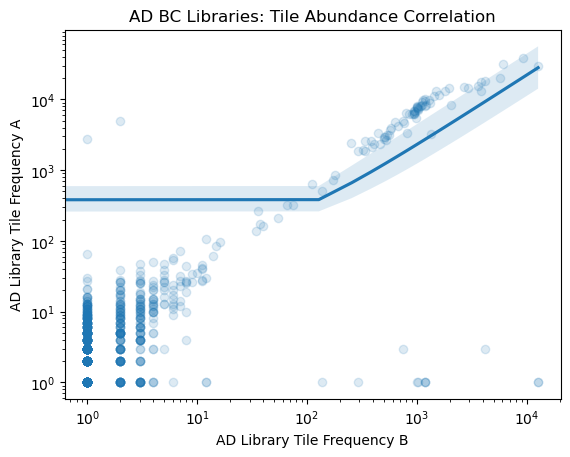

In [56]:
sns.regplot(x='ADbcs_1', y='ADbcs_0', data=addata_merge, scatter_kws={'alpha':0.15})

plt.title('AD BC Libraries: Tile Abundance Correlation')
plt.xlabel('AD Library Tile Frequency B')
plt.ylabel('AD Library Tile Frequency A')
plt.xscale('log')
plt.yscale('log')

# plt.savefig('cibervi_ADlibcorr_log.png', dpi=300, format='png')
plt.show()

In [48]:
addata_merge_out = admatch1.merge(admatch0, how='outer', on='Tiles', suffixes=('_1', '_0'))
addata_merge_out = addata_merge_out.fillna(0)
addata_merge_out

,index_1,BCs_1,TBB_1,Tiles,index_0,BCs_0,TBB_0
0,TGGCGGGGAGG,12676.0,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...,TGGCGGGGAGG,30245.0,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...
1,TGGCGGGGAGG,12676.0,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...,TACAACATCGC,1.0,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...
2,TGGCGGGGAGG,12676.0,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...,CATCCTTACAA,1.0,TCTTCTTTGTTTCCAGATTCTCATATTTCTGGTGAAGACTTTGATA...
3,TACTTCATCAC,9198.0,GATGCATTTACTCCATTTGAAGGTGGTGCTTCTGTTACTAATGCAT...,GATGCATTTACTCCATTTGAAGGTGGTGCTTCTGTTACTAATGCAT...,TACTTCATCAC,38470.0,GATGCATTTACTCCATTTGAAGGTGGTGCTTCTGTTACTAATGCAT...
4,TCTCTAACTGC,6087.0,TCTTCTACTGCTTTGCAAAGAAGAGGTCATCCATCTAGACCACCAG...,TCTTCTACTGCTTTGCAAAGAAGAGGTCATCCATCTAGACCACCAG...,TCTCTAACTGC,31440.0,TCTTCTACTGCTTTGCAAAGAAGAGGTCATCCATCTAGACCACCAG...
...,...,...,...,...,...,...,...
2735,0,0.0,0,AATTTGGATTCTTCTGTTTCTCCATCTGCTTCTCCACATGCTAGAT...,AAAGGACCGCA,1.0,AATTTGGATTCTTCTGTTTCTCCATCTGCTTCTCCACATGCTAGAT...
2736,0,0.0,0,AAATCTCATCAAGACTTCTCTTTGCCAGATCCACAACCACAACCAC...,AACCGTCTTTC,1.0,AAATCTCATCAAGACTTCTCTTTGCCAGATCCACAACCACAACCAC...
2737,0,0.0,0,TCTTTGTTTCCAGAAGAAGAGAATAAATTGCATGAAGTTGCTCAAT...,AAGACATTCGC,1.0,TCTTTGTTTCCAGAAGAAGAGAATAAATTGCATGAAGTTGCTCAAT...
2738,0,0.0,0,GGTTCTTTGATTGAATCTGCTTATAGAGCTGCTCCAACTGAAATGA...,TCTCTAACGGC,1.0,GGTTCTTTGATTGAATCTGCTTATAGAGCTGCTCCAACTGAAATGA...


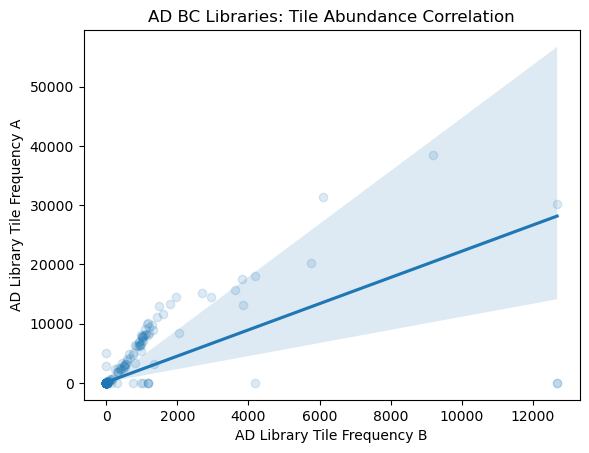

In [58]:
sns.regplot(x='BCs_1', y='BCs_0', data=addata_merge_out, scatter_kws={'alpha':0.15})

plt.title('AD BC Libraries: Tile Abundance Correlation')
plt.xlabel('AD Library Tile Frequency B')
plt.ylabel('AD Library Tile Frequency A')
# plt.xscale('log')
# plt.yscale('log')

# plt.savefig('cibervi_ADlibcorr_outer.png', dpi=300, format='png')
plt.show()

In [61]:
addata_merge_out.corr(numeric_only=True)

,BCs_1,BCs_0
BCs_1,1.000000,0.693136
BCs_0,0.693136,1.000000


In [59]:
#this likely doesn't work because I'm merging on TBB rather than on TILE which is the actual thing that will be shared between the two, rather than TBB ? 
# esp bc currently the AD:TBB system excludes many TBB combos
alldata_merge = addata_merge.merge(rptrdata_merge, how='inner', on='Tiles', suffixes=('_1', '_0'))
alldata_merge

,index_1_1,ADbcs_1,Tiles,index_0_1,ADbcs_0,TBB_0_1,index_1_0,RPTRbcs_1,TBB_1,index_0_0,RPTRbcs_0,TBB_0_0
0,CGATATATTGC,3.0,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,CGATATATTGC,9.0,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,TGGAGAAAGAAAAG,12,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,TGGAGAAAGAAAAG,6,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...
1,CGATATATTGC,3.0,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,CCCTAAACCAT,4.0,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,TGGAGAAAGAAAAG,12,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,TGGAGAAAGAAAAG,6,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...
2,CGATATATTGC,3.0,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,TGCTAGTGTCG,1.0,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,TGGAGAAAGAAAAG,12,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,TGGAGAAAGAAAAG,6,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...
3,TTATAGATGTT,3.0,CAGAAACATACTTCTGTTGATAGAACTTTGCAACAAGATAGATTGG...,TTATAGATGTT,6.0,CAGAAACATACTTCTGTTGATAGAACTTTGCAACAAGATAGATTGG...,TTTAACGCATGAGA,8,CAGAAACATACTTCTGTTGATAGAACTTTGCAACAAGATAGATTGG...,TTTAACGCATGAGA,2,CAGAAACATACTTCTGTTGATAGAACTTTGCAACAAGATAGATTGG...
4,GGACTAGTAAC,2.0,GTTATTACTGATTCTCAATCTACTTGGTTGCCATCTTCTACTTCTT...,GGACTAGTAAC,4.0,GTTATTACTGATTCTCAATCTACTTGGTTGCCATCTTCTACTTCTT...,AATTATAAAAACGC,11,GTTATTACTGATTCTCAATCTACTTGGTTGCCATCTTCTACTTCTT...,AATTATAAAAACGC,7,GTTATTACTGATTCTCAATCTACTTGGTTGCCATCTTCTACTTCTT...
5,ACTAGGCGTGC,1.0,TTGTTGTTTAGAAATCCAGCTGATACTTCTCCATCTTCATTCTCTC...,ACTAGGCGTGC,66.0,TTGTTGTTTAGAAATCCAGCTGATACTTCTCCATCTTCATTCTCTC...,TTGATAAATAAAAT,3,TTGTTGTTTAGAAATCCAGCTGATACTTCTCCATCTTCATTCTCTC...,TTGATAAATAAAAT,1,TTGTTGTTTAGAAATCCAGCTGATACTTCTCCATCTTCATTCTCTC...
6,ACTAGGCGTGC,1.0,TTGTTGTTTAGAAATCCAGCTGATACTTCTCCATCTTCATTCTCTC...,ACTAGGCGTGC,66.0,TTGTTGTTTAGAAATCCAGCTGATACTTCTCCATCTTCATTCTCTC...,AATATAAATTAAGC,1,TTGTTGTTTAGAAATCCAGCTGATACTTCTCCATCTTCATTCTCTC...,TTGATAAATAAAAT,1,TTGTTGTTTAGAAATCCAGCTGATACTTCTCCATCTTCATTCTCTC...
7,0,0.0,CAAGCTCATTTGTCTCCAGCTTCTTCTAGAATTGAAGTTGCTTCTT...,GATGATGATCA,10.0,CAAGCTCATTTGTCTCCAGCTTCTTCTAGAATTGAAGTTGCTTCTT...,TGGAGTATTAAAAT,1,CAAGCTCATTTGTCTCCAGCTTCTTCTAGAATTGAAGTTGCTTCTT...,TGGAGTATTAAAAT,1,CAAGCTCATTTGTCTCCAGCTTCTTCTAGAATTGAAGTTGCTTCTT...
8,0,0.0,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,TTCCCTAGGGG,4.0,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,TTTAACGCATGAGT,15848,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...,TTTAACGCATGAGT,8754,CCATCTCAATTGCAGAATACTACTCCAAATTCTCCACAACCAACTA...
9,0,0.0,GTTAGGAAGAGAACTAATCCATTGCCACCAATTGTTGTTGAAGATC...,GTCCGCCTTAA,4.0,GTTAGGAAGAGAACTAATCCATTGCCACCAATTGTTGTTGAAGATC...,CTTCTAAATAACGC,4,GTTAGGAAGAGAACTAATCCATTGCCACCAATTGTTGTTGAAGATC...,CTTCTAAATAACGC,1,GTTAGGAAGAGAACTAATCCATTGCCACCAATTGTTGTTGAAGATC...


In [62]:
#okay look at it between similar sequencing libraries


run1_merge = admatch1.merge(rptrmatch1, how='inner', on='Tiles', suffixes=('_ad', '_rptr'))
run1_merge = run1_merge.fillna(0)

run1_merge

,index_ad,BCs_ad,TBB_ad,Tiles,index_rptr,BCs_rptr,TBB_rptr
0,CGATATATTGC,3,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...,TGGAGAAAGAAAAG,12,CCATCTGCTTCTTGTTCTCCATCTACTCCATCTCCATCTCATTCTC...
1,TTATAGATGTT,3,CAGAAACATACTTCTGTTGATAGAACTTTGCAACAAGATAGATTGG...,CAGAAACATACTTCTGTTGATAGAACTTTGCAACAAGATAGATTGG...,TTTAACGCATGAGA,8,CAGAAACATACTTCTGTTGATAGAACTTTGCAACAAGATAGATTGG...
2,GGACTAGTAAC,2,GTTATTACTGATTCTCAATCTACTTGGTTGCCATCTTCTACTTCTT...,GTTATTACTGATTCTCAATCTACTTGGTTGCCATCTTCTACTTCTT...,AATTATAAAAACGC,11,GTTATTACTGATTCTCAATCTACTTGGTTGCCATCTTCTACTTCTT...
3,GGACGAGGAAC,2,TTTGATTCTAATGATCCAGTTGCTATGAAGAGAGCTAGAAATACTG...,TTTGATTCTAATGATCCAGTTGCTATGAAGAGAGCTAGAAATACTG...,CCTTTTAAATAAGC,3,TTTGATTCTAATGATCCAGTTGCTATGAAGAGAGCTAGAAATACTG...
4,TTGAAAATCGC,1,TCTACTCCAAACTTTATGGAAGCTCATGAAGTTGATTTGTTTGGTT...,TCTACTCCAAACTTTATGGAAGCTCATGAAGTTGATTTGTTTGGTT...,ATTTTTAAATTAGC,1,TCTACTCCAAACTTTATGGAAGCTCATGAAGTTGATTTGTTTGGTT...
5,CTCCCTAGGGA,1,TTTAGAGATCATGAAGTTAGAGTTGAAGGTGATAGAGTTGTTAATA...,TTTAGAGATCATGAAGTTAGAGTTGAAGGTGATAGAGTTGTTAATA...,CGTCCAACGAATCT,1,TTTAGAGATCATGAAGTTAGAGTTGAAGGTGATAGAGTTGTTAATA...
6,ACTAGGCGTGC,1,TTGTTGTTTAGAAATCCAGCTGATACTTCTCCATCTTCATTCTCTC...,TTGTTGTTTAGAAATCCAGCTGATACTTCTCCATCTTCATTCTCTC...,TTGATAAATAAAAT,3,TTGTTGTTTAGAAATCCAGCTGATACTTCTCCATCTTCATTCTCTC...
7,ACTAGGCGTGC,1,TTGTTGTTTAGAAATCCAGCTGATACTTCTCCATCTTCATTCTCTC...,TTGTTGTTTAGAAATCCAGCTGATACTTCTCCATCTTCATTCTCTC...,AATATAAATTAAGC,1,TTGTTGTTTAGAAATCCAGCTGATACTTCTCCATCTTCATTCTCTC...
8,TATCTAACTGC,1,ACTGGTTCTATTGCTTCTTCTACTTCTCCACAACAATCTAATCCAA...,ACTGGTTCTATTGCTTCTTCTACTTCTCCACAACAATCTAATCCAA...,TGTTCTAATTAAGG,1,ACTGGTTCTATTGCTTCTTCTACTTCTCCACAACAATCTAATCCAA...
9,CCGGTTATCAA,1,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...,ATCAATCGACATTT,1,TTGACTGCTTTGACTTCTCCATCTTTGTTTGATGGTTCTCCAGACT...


In [63]:
run1_merge.corr(numeric_only=True)

,BCs_ad,BCs_rptr
BCs_ad,1.00000,0.86606
BCs_rptr,0.86606,1.00000


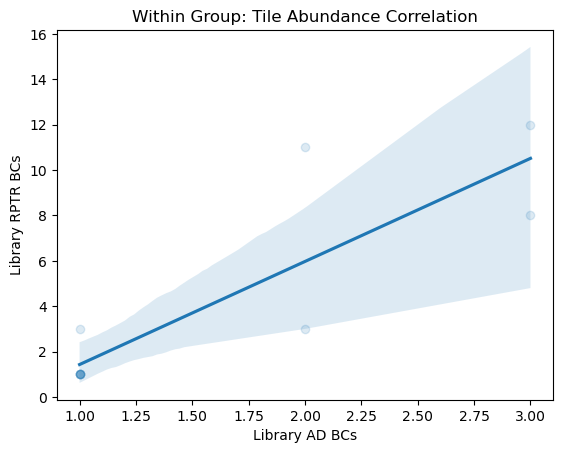

In [64]:
sns.regplot(x='BCs_ad', y='BCs_rptr', data=run1_merge, scatter_kws={'alpha':0.15})

plt.title('Within Group: Tile Abundance Correlation')
plt.xlabel('Library AD BCs')
plt.ylabel('Library RPTR BCs')
plt.show()

In [ ]:
sns.regplot(x='BCs_ad', y='BCs_rptr', data=run1_merge, scatter_kws={'alpha':0.15})

plt.title('Within Group: Tile Abundance Correlation')
plt.xlabel('Library AD BCs')
plt.ylabel('Library RPTR BCs')
plt.show()

In [70]:
#save useful tables into database

# conn.sql("CREATE TABLE SI_VI_RPTR0 AS SELECT * FROM rptrmatch0")
# conn.sql("CREATE TABLE SI_VI_RPTR1 AS SELECT * FROM rptrmatch1")
# conn.sql("CREATE TABLE SI_VI_AD0 AS SELECT * FROM admatch0")
# conn.sql("CREATE TABLE SI_VI_AD1 AS SELECT * FROM admatch1")

In [71]:
conn.sql("SHOW ALL TABLES")

┌──────────┬─────────┬─────────────┬───────────────────────────┬──────────────────────────────────────┬───────────┐
│ database │ schema  │    name     │       column_names        │             column_types             │ temporary │
│ varchar  │ varchar │   varchar   │         varchar[]         │              varchar[]               │  boolean  │
├──────────┼─────────┼─────────────┼───────────────────────────┼──────────────────────────────────────┼───────────┤
│ mydb     │ main    │ SI_VI_AD0   │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ SI_VI_AD1   │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ SI_VI_RPTR0 │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ SI_VI_RPTR1 │ [index, BCs, TBB, Tiles]  │ [VARCHAR, BIGINT, VARCHAR, VARCHAR]  │ false     │
│ mydb     │ main    │ TBB         │ [Tiles, ADbc, RPTRbc]     │ [VARCHA

In [65]:
pwd

'/global/scratch/users/empchase/CiberVI/Analysis'